In [37]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm.notebook import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [28]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

In [29]:
#parent_path = str(pathlib.Path(os.path.normpath('C:\\Users\\lms-puvvalat\\Documents\\GitHub\\2022-svsm-afib-group1\\')))
parent_path = str(pathlib.Path(os.getcwd()).parent.parent)

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [30]:
moving_accuracy = {}

In [31]:
def score_reporter(initial_results):
    initial_columns = initial_results.axes[0].tolist()
    results = initial_results.dropna()
    changed_columns = results.axes[0].tolist()
    
    dropped_cols = list(set(initial_columns).difference(changed_columns))
    
    print(dropped_cols)

    acc_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_accuracy'
        if col_name not in dropped_cols:
            acc_scores.append(results[col_name])

    spec_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_specificity'
        if col_name not in dropped_cols:
            spec_scores.append(results[col_name])

    sens_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_sensitivity'
        if col_name not in dropped_cols:
            sens_scores.append(results[col_name])


    prec_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_precision'
        if col_name not in dropped_cols:
            prec_scores.append(results[col_name])

    f1_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_f1_score'
        if col_name not in dropped_cols:
            f1_scores.append(results[col_name])
        
    elapsed_times = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_elapsed'
        if col_name not in dropped_cols:
            elapsed_times.append(results[col_name])

    eps_times = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_eps'
        if col_name not in dropped_cols:
            eps_times.append(results[col_name])

    print('---Run time of each fold: \n {}'.format(elapsed_times))
    print("Avg run time: {}".format(np.mean(elapsed_times)))
    print('---Run time per subset of each fold is: \n {}'.format(eps_times))
    print("Avg run time per subset: {}".format(np.mean(eps_times)))
    print()
    print('Accuracy of each fold: \n {}'.format(acc_scores))
    print("Avg accuracy: {}".format(np.mean(acc_scores)))
    print('Std of accuracy : \n{}'.format(np.std(acc_scores)))
    print()
    print('Specificity of each fold: \n {}'.format(spec_scores))
    print("Avg specificity: {}".format(np.mean(spec_scores)))
    print('Std of specificity: \n{}'.format(np.std(spec_scores)))
    print()
    print('Sensitivity of each fold: \n {}'.format(sens_scores))
    print("Avg sensitivity: {}".format(np.mean(sens_scores)))
    print('Std of sensitivity: \n{}'.format(np.std(sens_scores)))
    print()
    print('Precision of each fold: \n {}'.format(prec_scores))
    print("Avg precision: {}".format(np.mean(prec_scores)))
    print('Std of precision : \n{}'.format(np.std(prec_scores)))
    print()
    print('F1-scores of each fold: \n {}'.format(f1_scores))
    print("Avg F1-scores: {}".format(np.mean(f1_scores)))
    print('Std of F1-scores : \n{}'.format(np.std(f1_scores)))

In [32]:
def scorer(clf, X, y):
    global moving_acc

    start_time = timeit.default_timer()
    y_pred = clf.predict(X)
    elapsed = timeit.default_timer() - start_time

    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(y_pred):
        total_seen+=1
        if pred==y.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)
    moving_acc.append(subject_acc)

    fold_size = len(X)

    cm = confusion_matrix(y, y_pred)

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    return {'sensitivity': sensitivity, 'specificity': specificity,
            'precision': precision, 'f1_score': f1_score,
            'accuracy': accuracy_score(y, y_pred), 
            'elapsed': elapsed, 'eps': elapsed/fold_size}

In [38]:
feature_experiment_path = pathlib.Path(os.getcwd()).parent.parent /  'mit-bih-time-features-experiment'

dirs = [str(x) for x in feature_experiment_path.iterdir() if x.is_dir()]

for dir in tqdm(dirs):
    print(dir)
    feature_dfs = {}
    for record in rlist:
        feature_dfs[record] = pd.read_csv(os.path.normpath(dir+'/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

    combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

    X = combined_features[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'rmssd', 'iqr', 'mad', 'cov']]
    y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
    groups = combined_features['subjectID'].astype('int64')

    logo = LeaveOneGroupOut()
    splits = list(logo.split(X, y, groups=groups))

    # Decision tree
    moving_accuracy['decision_tree'] = []

    moving_acc = []

    print("model fit started")
    decision_tree = DecisionTreeClassifier(max_depth=10, random_state=2)
    cv_results = cross_validate(decision_tree, X, y, scoring=scorer, cv=splits, verbose=2)
    print("model fit completed")

    moving_accuracy['decision_tree'] = moving_acc

    '''
    print(decision_tree.feature_importances_)
    Importance = pd.DataFrame({'Importance':(decision_tree.feature_importances_*100)[0:12]}, 
                        index = (X.columns)[0:12])
    Importance.sort_values(by = 'Importance', 
                    axis = 0, 
                    ascending = True).plot(kind = 'barh', 
                                            color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = 
    '''

    results = pd.DataFrame(cv_results)
    #os.mkdir(os.path.normpath(parent_path + '/models/subsets/results/'))
    #results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/decision_tree_results.csv'))
    print('-------'+dir+'-------')
    print(results)

    #score_reporter(results.iloc[randomsearch.best_index_])

    print(np.mean(results['test_accuracy']))
    print(np.mean(results['test_specificity']))
    print(np.mean(results['test_sensitivity']))
    print(np.mean(results['test_precision']))
    print(np.mean(results['test_f1_score']))

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.55
model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.0s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.55-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   2.164816    0.061020          0.898160          0.977273    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   47.5s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.3s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.65-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   2.105410    0.073469          0.897329          0.931818    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   46.6s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.4s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.3s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.25-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   2.502898    0.043863          0.899958          0.954545    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   54.6s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   1.6s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s
[CV] END .................................................... total time=   1.7s
[CV] END .................................................... total time=   1.6s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.85-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   1.623217    0.042337          0.897468          0.931818    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   38.0s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.5s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.4s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.15-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   2.446717    0.044746          0.901204          0.931818    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   56.9s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.2s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.35-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   2.218549    0.043790          0.894285          0.988636    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   51.4s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   1.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   1.8s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.8s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.75-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   1.779686    0.040642          0.894977          0.954545    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   41.6s finished


model fit started


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.1s


/var/folders/15/psv1y74j5nbdx6lvs_xw8jgm0000gn/T/ipykernel_1283/1056965083.py:22: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
model fit completed
-------/Users/arisingh/Documents/GitHub/2022-svsm-afib-group1/mit-bih-time-features-experiment/0.45-------
    fit_time  score_time  test_sensitivity  test_specificity  test_precision  \
0   2.156209    0.043390          0.893593          0.988636    

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   49.2s finished


In [19]:
print(np.mean(results['test_accuracy']))

0.9179499289587065


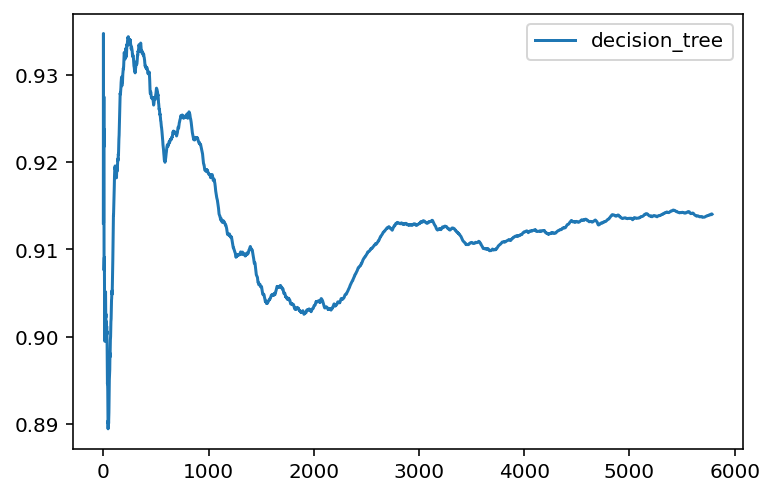

In [16]:
for classifier in moving_accuracy:
    minLen = len(moving_accuracy[classifier][0])
    for list in moving_accuracy[classifier]:
        if len(list)<minLen:
            minLen = len(list)

    for list in moving_accuracy[classifier]:
        list = list[:minLen]

    avg_list = [sum(sub_list) / len(sub_list) for sub_list in zip(*moving_accuracy[classifier])]
    plt.plot(avg_list, label = classifier)
    plt.legend()